In [29]:
from tensorflow.keras.models import load_model


In [29]:
# This was displaying how the filter outputs the image.

In [30]:
model_1 = load_model('Network_1.h5')

In [31]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [32]:
from tensorflow.keras.preprocessing import image

In [53]:
img = image.load_img('11237.jpg',target_size = (150,150))

In [54]:
img = image.img_to_array(img)

In [55]:
img/=255

In [56]:
img.shape

(150, 150, 3)

In [57]:
import numpy as np

In [58]:
img = np.expand_dims(img,axis = 0)

In [59]:
img.shape

(1, 150, 150, 3)

In [60]:
import matplotlib.pyplot as plt

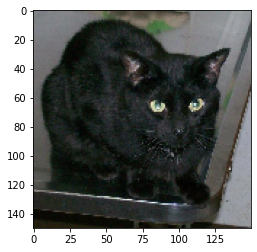

In [61]:
plt.imshow(img[0])

In [62]:
from tensorflow.keras import models

In [63]:
layer_output = [layer.output for layer in model_1.layers[:8]]

In [64]:
activation_model = models.Model(inputs=model_1.input,outputs = layer_output)

In [65]:
activations = activation_model.predict(img)

In [66]:
first_layer = activations[0]

In [67]:
len(activations)

8

In [68]:
first_layer.shape  # basically it has 32 photos or 32 activation, we can choose the ith activation for plotting

(1, 148, 148, 32)

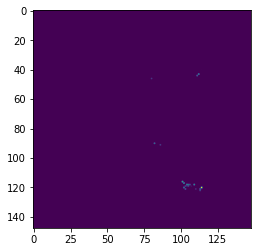

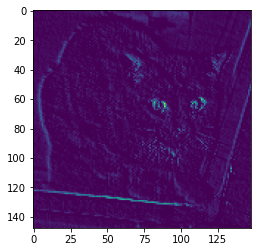

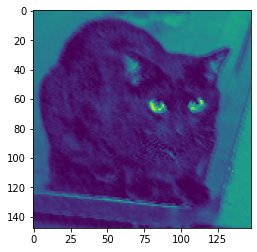

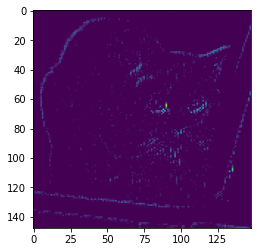

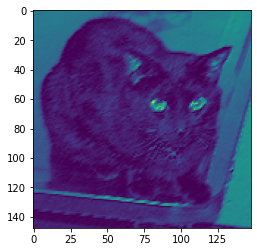

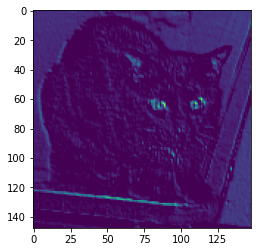

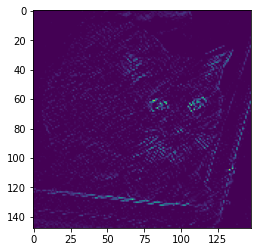

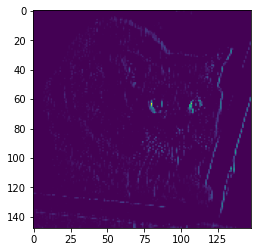

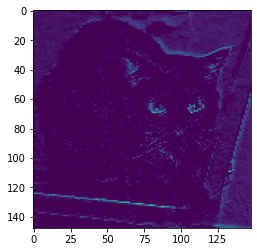

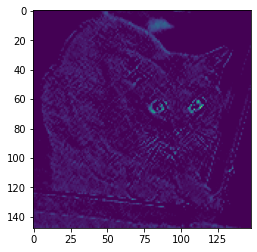

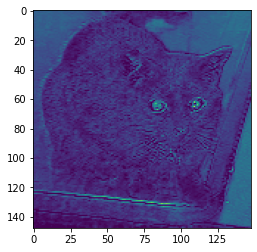

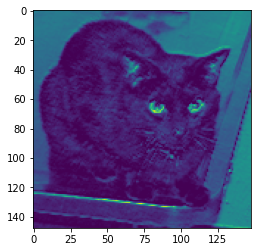

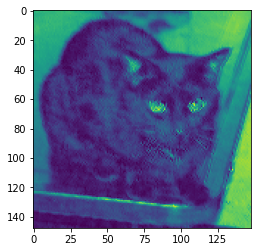

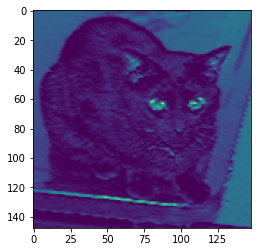

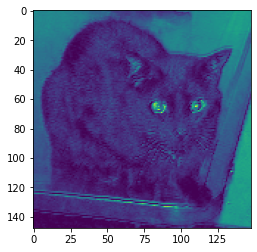

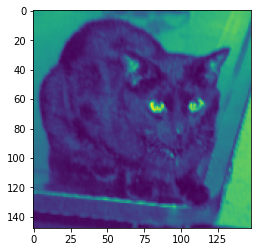

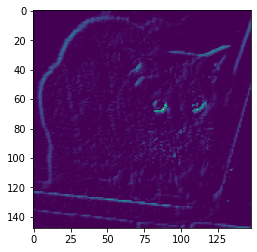

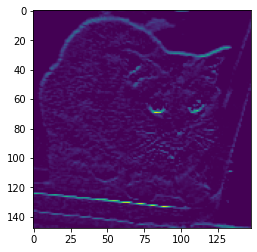

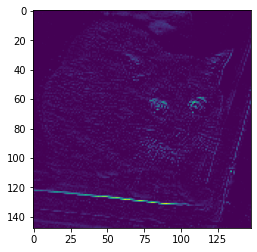

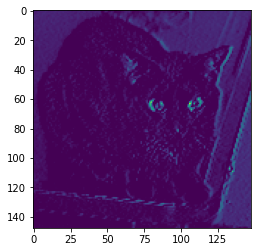

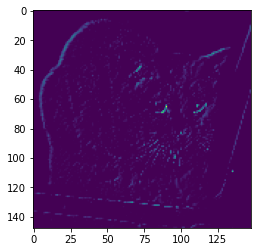

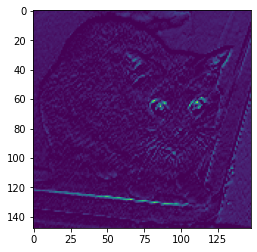

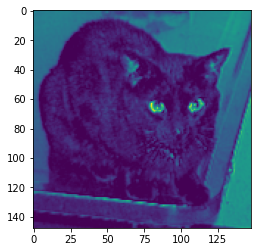

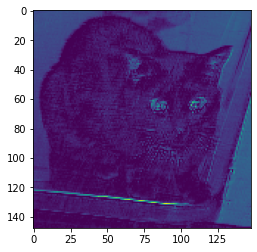

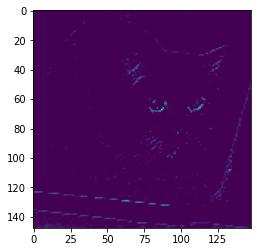

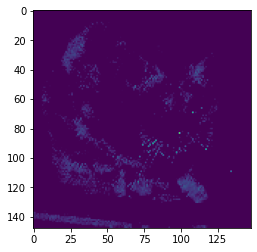

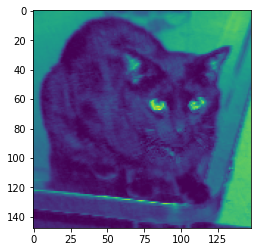

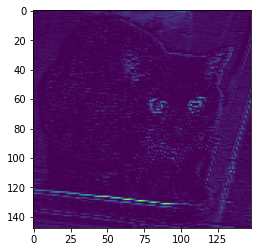

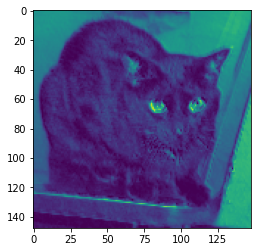

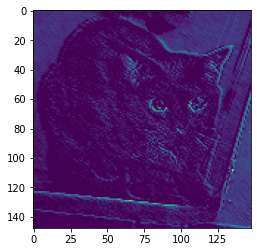

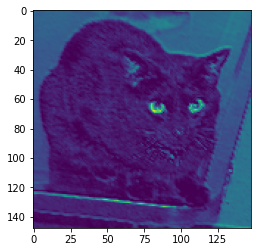

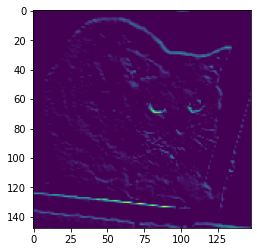

In [69]:
for i in range(32):
  plt.imshow(first_layer[0,:,:,i])
  plt.show()

In [70]:
layer_names = [layer.name for layer in model_1.layers]
image_per_row = 16


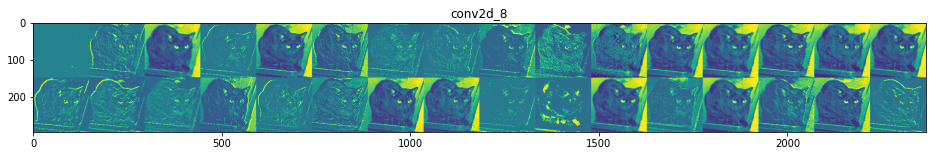

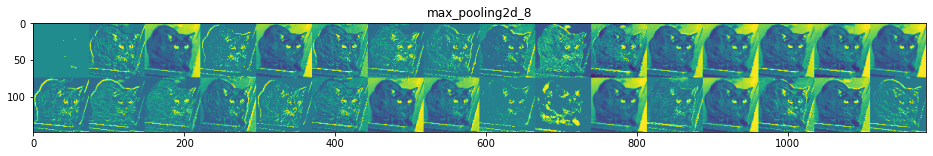

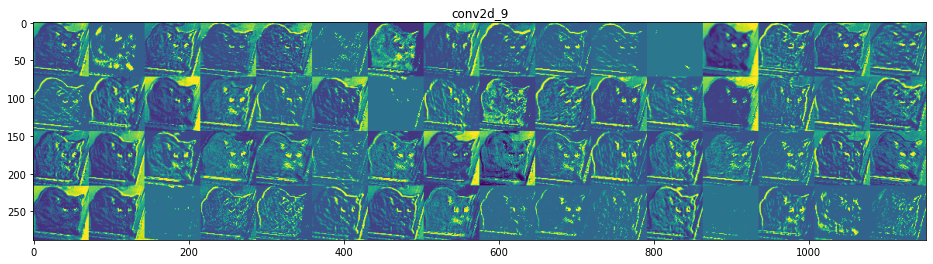

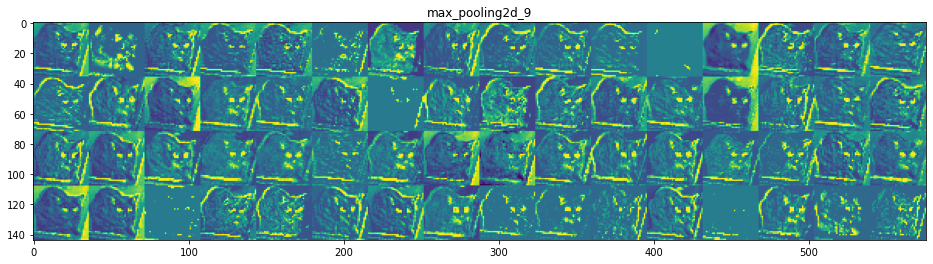

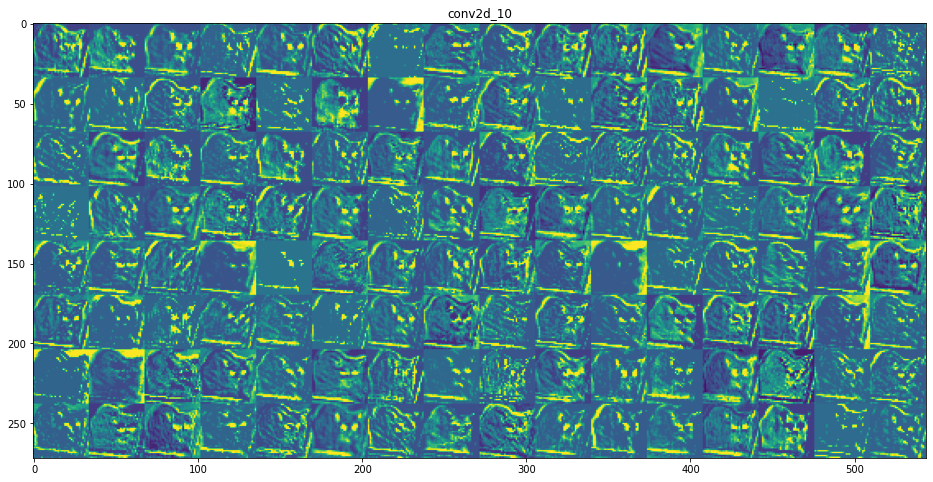

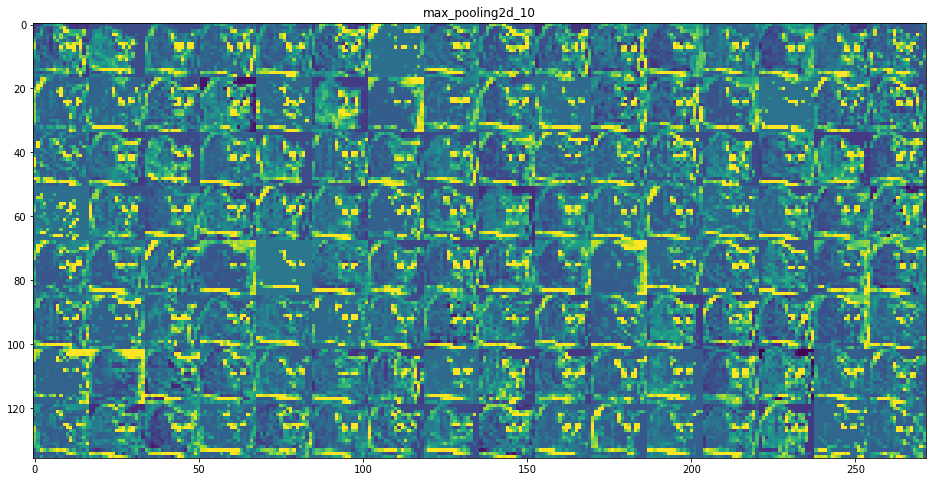

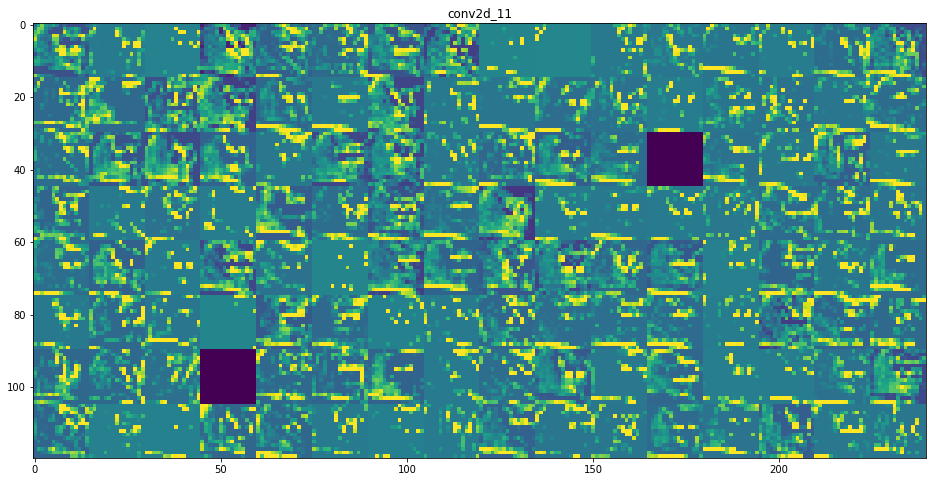

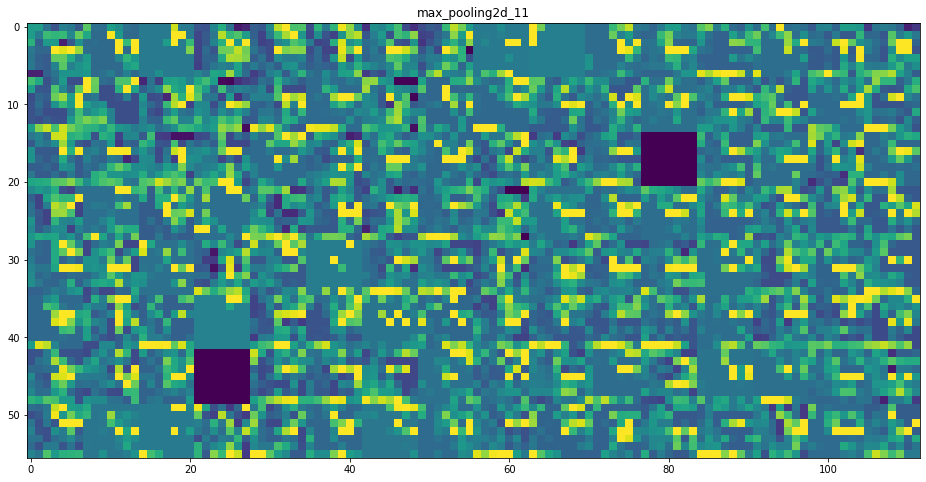

In [72]:
for layer_name, layer_activation in zip(layer_names,activations):
  n_feature = layer_activation.shape[-1] # How many filters or features are in the layer
  size = layer_activation.shape[1] # Number of pixels a single filter or feature
  n_cols = n_feature//image_per_row # number of pictures in a single row
  display_grid = np.zeros((size*n_cols,image_per_row*size))
  for col in range(n_cols):
    for row in range(image_per_row):
      channel_image = layer_activation[0,:,:,col*image_per_row+row]
      channel_image-=channel_image.mean()
      channel_image/= channel_image.std()
      channel_image*=64
      channel_image+=128
      channel_image = np.clip(channel_image,0,255).astype('uint8')
      display_grid[col*size:(col+1)*size,row*size:(row+1)*size]=channel_image
  scale = 1./size
  plt.figure(figsize =(scale*display_grid.shape[1],scale*display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid,aspect='auto',cmap='viridis')

In [73]:
#Displaying the pattern to which filters responds

In [117]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as k

In [118]:
model = VGG16(weights = 'imagenet',include_top = False)

In [119]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [120]:
layer_name ='block3_conv1'
filter_index = 0
import tensorflow
import numpy as np

In [121]:
layer_output = model.get_layer(layer_name).output
layer_output.shape # As there is no image, hence it is None on every index, except the filter which are the patterns it detectsc

TensorShape([None, None, None, 256])

In [122]:
try:
  loss = k.mean(layer_output[:,:,:,filter_index])
except RecursionError:
  print('nope')

In [123]:
tensorflow.compat.v1.disable_eager_execution()
grad = k.gradients(loss,model.input)[0]

In [124]:
grad /= (k.sqrt(k.mean(k.square(grad))) + 1e-5)

In [125]:
iterate = k.function([model.input],[loss,grad])

In [126]:
loss_value,grad_value = iterate([np.zeros((1,150,150,3))])

In [127]:
#loss maximisation

In [128]:
input_img_array = np.random.random((1,150,150,3))*20+128

In [129]:
step = 1
for i in range(40):
  loss_v,grad_v = iterate(input_img_array)
  input_img_array+=grad_v
  

In [130]:
#Post process the image as it wont be in the range of 0 to 255, normalise and clip and then change it to RGB

In [131]:
def post_process(x):
  x-=x.mean()
  x/=(x.std()+1e-5)
  x*=0.1
  #Normalisation
  x+=0.5
  x = np.clip(x,0,1)
  #clip to 0 to 1
  x*=255
  x=np.clip(x,0,255).astype('uint8')
  return x
  


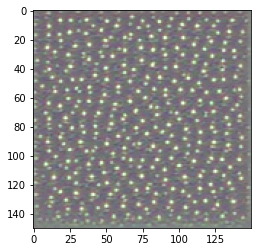

In [132]:
image_maxed = post_process(input_img_array)
plt.imshow(image_maxed[0])

In [133]:
#putting everything in a single function


In [135]:
def generate_pattern(layer_name,filter_index,size=150):
  layer_out = model.get_layer(layer_name).output
  loss = k.mean(layer_out[:,:,:,filter_index])
  gradient = k.gradients(loss,model.input)[0]
  gradient/=(k.sqrt(k.mean(k.square(gradient)))+1e-5)
  iterate = k.function([model.input],[loss,gradient])
  input_img_data = np.random.random((1,size,size,3))*20+128
  step = 1
  for i in range(40):
    loss_val,grad_val = iterate([input_img_data])
    input_img_data+=grad_val*step
  img = input_img_data[0]
  return post_process(img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


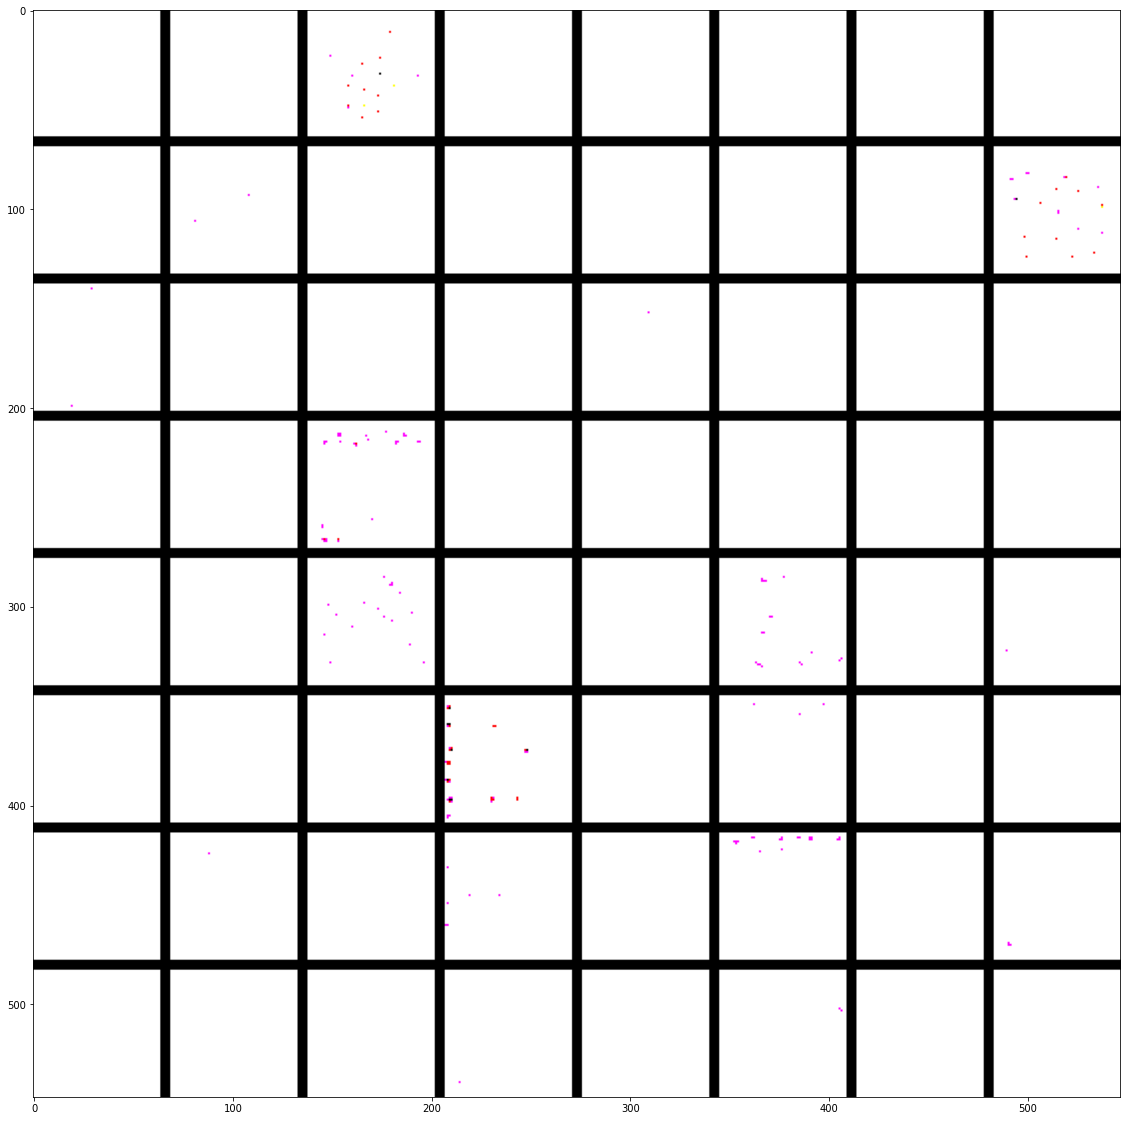

In [138]:
layer_name = 'block3_conv1'
size = 64
margin = 5
results = np.zeros((8 * size+7* margin, 8 * size+7* margin, 3))
for i in range(8):
  for j in range(8):
    filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
    horizontal_start = i * size + i * margin
    horizontal_end = horizontal_start + size
    vertical_start = j * size + j * margin
    vertical_end = vertical_start + size
    results[horizontal_start: horizontal_end,vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(20, 20))
plt.imshow(results)